# Trying vector codings 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from Bio.Data import IUPACData
from collections import defaultdict
from itertools import product, combinations
from scipy.spatial.distance import hamming
import scipy.stats as ss
import cvxpy as cp
import sys
import scipy.linalg as sl

sys.path.append("../") 
import doe_utils

# TEST MAKE AMINO ACID WORLD SMALL 

AMINO_ACIDS = doe_utils.AMINO_ACIDS

In [2]:
length_of_protein = 100
num_mutated = 5
sold_mat_df, parent, mut_dict = doe_utils.create_synthetic_SOLD_matrix(num_mutated, length_of_protein, \
                                #mut_probs = [[0.45], [0.35, 0.35], [0.45], [0.35, 0.35]], parent_prob=[0.55, 0.30, 0.55, 0.30])                                      
                                #mut_probs = [[0.45, 0.45], [0.45], [0.20, 0.20, 0.20], [0.20, 0.20, 0.20]], parent_prob=[0.10, 0.55, 0.40, 0.40])                                    
                                mut_probs = [[0.45, 0.45], [0.45, 0.45], [0.25, 0.3, 0.35], [0.25, 0.25, 0.4], [0.45, 0.45]], parent_prob=[0.10, 0.10, 0.10, 0.10, 0.10]) #6 postions mutated, pprtein length is 100 
sold_mat_df.head() 

Parent protein: IEDWKFKPCVLQSDESMKIMHMPIGKFTMQKAYEASHQQPTKTMHKFNGFNAEMWQNSNFDVAWQLCTMNYLHTGCRSCRMKCYSRLRKANQRHHEKNWL
Random mutaed positions [18 34 57 63 75]


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


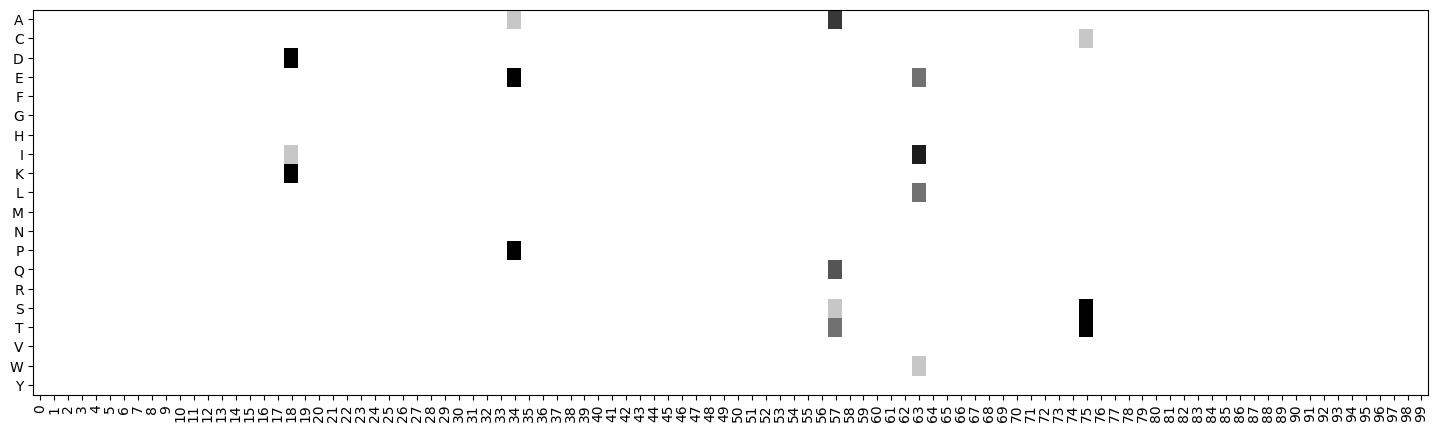

In [3]:
plt.figure(figsize = (18,5))
plt.imshow(sold_mat_df, aspect = 'auto', cmap = 'grey_r') 
_  = plt.xticks(range(length_of_protein), rotation = 90)
_  = plt.yticks(range(len(AMINO_ACIDS)), AMINO_ACIDS)


In [4]:
S = doe_utils.SOLD(sold_mat_df)
seqs, mutations = S.generate_sequences(10000)
seqs = np.unique(seqs)
print(len(seqs))
probs = S.compute_prob_n_mutations(num_mutated+1)

405


In [5]:
S.mutation_probs_variable_region_indexed

defaultdict(None,
            {0: {'D': 0.45, 'I': 0.1, 'K': 0.45},
             1: {'A': 0.1, 'E': 0.45, 'P': 0.45},
             2: {'A': 0.35, 'Q': 0.3, 'S': 0.1, 'T': 0.25},
             3: {'E': 0.25, 'I': 0.4, 'L': 0.25, 'W': 0.1},
             4: {'C': 0.1, 'S': 0.45, 'T': 0.45}})

# Now you have variable length mat to create encoder 

In [6]:
Q = doe_utils.Encoding_basics(S.mutation_probs_variable_region_indexed)

Q.pairwise_code_mapper

{'0:1': {'IA': array([1., 0., 0., 0.]),
  'IP': array([0., 1., 0., 0.]),
  'KA': array([0., 0., 1., 0.]),
  'KP': array([0., 0., 0., 1.]),
  'DE': array([0., 0., 0., 0.]),
  'DA': array([0., 0., 0., 0.]),
  'DP': array([0., 0., 0., 0.]),
  'IE': array([0., 0., 0., 0.]),
  'KE': array([0., 0., 0., 0.])},
 '0:2': {'IQ': array([1., 0., 0., 0., 0., 0.]),
  'IS': array([0., 1., 0., 0., 0., 0.]),
  'IT': array([0., 0., 1., 0., 0., 0.]),
  'KQ': array([0., 0., 0., 1., 0., 0.]),
  'KS': array([0., 0., 0., 0., 1., 0.]),
  'KT': array([0., 0., 0., 0., 0., 1.]),
  'DA': array([0., 0., 0., 0., 0., 0.]),
  'DQ': array([0., 0., 0., 0., 0., 0.]),
  'DS': array([0., 0., 0., 0., 0., 0.]),
  'DT': array([0., 0., 0., 0., 0., 0.]),
  'IA': array([0., 0., 0., 0., 0., 0.]),
  'KA': array([0., 0., 0., 0., 0., 0.])},
 '0:3': {'IE': array([1., 0., 0., 0., 0., 0.]),
  'IL': array([0., 1., 0., 0., 0., 0.]),
  'IW': array([0., 0., 1., 0., 0., 0.]),
  'KE': array([0., 0., 0., 1., 0., 0.]),
  'KL': array([0., 0., 0

In [7]:
E = doe_utils.Sequence_encoder_simplex(S.mutation_probs_variable_region_indexed)
independent_codes, pairwise_codes, flatten_independent, flatter_pairwise = E.encode_seqs(seqs)  

In [8]:
pairwise_codes[0]

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0.])]

In [9]:
pairwise_codes[1]

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.])]

In [10]:
pairwise_codes[2]

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0.])]

In [11]:
seqs[0]

np.str_('DAAEC')

In [12]:
model = doe_utils.Create_in_silico_model(S.mutation_probs_variable_region_indexed)

[ True  True False False  True  True  True False False False  True  True
  True False False False  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False]
[False False  True  True False False False  True  True  True False False
 False  True  True  True False False  True  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False

/Users/swagatammukhopadhyay/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swagatammukhopadhyay/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/swagatammukhopadhyay/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/swagatammukhopadhyay/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/swagatammukhopadhyay/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods.

(array([ 4., 10., 28., 46., 59., 90., 82., 54., 25.,  7.]),
 array([-6.58348312, -5.55330507, -4.52312702, -3.49294897, -2.46277092,
        -1.43259286, -0.40241481,  0.62776324,  1.65794129,  2.68811934,
         3.71829739]),
 <BarContainer object of 10 artists>)

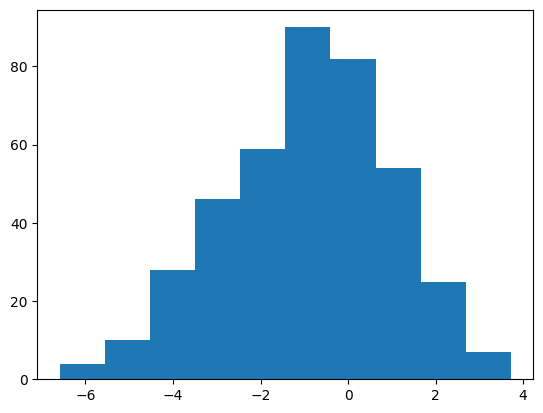

In [13]:
responses = model.model(flatten_independent, flatter_pairwise)
plt.hist(responses)

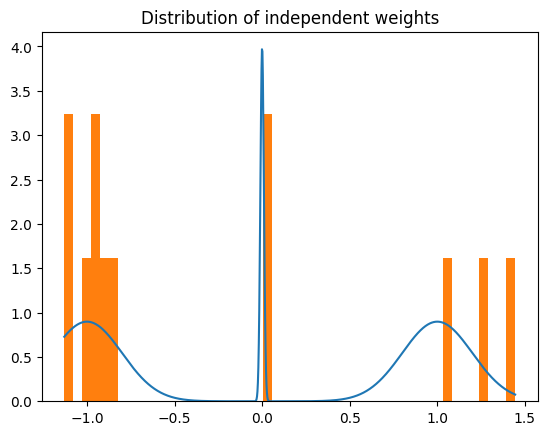

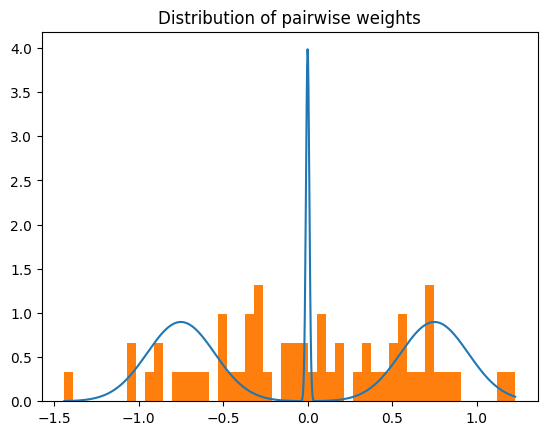

In [14]:
model.plot_weights()

In [15]:
Q.parent[0]

'D'

In [16]:
fit_model = doe_utils.Fitting_model(S.mutation_probs_variable_region_indexed)
weights, fit_responses = fit_model.fit(seqs, responses, fit = 'both')

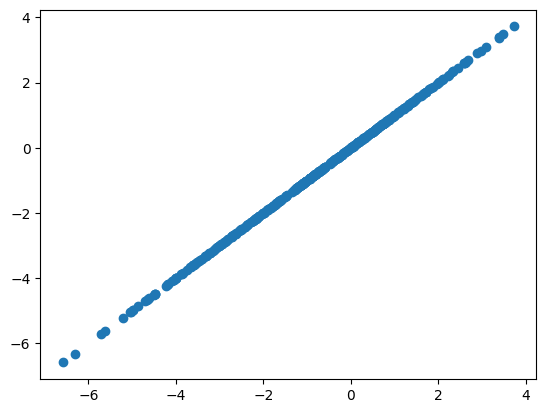

In [17]:
plt.scatter(fit_responses, responses)

Text(0, 0.5, 'fitted independent weights')

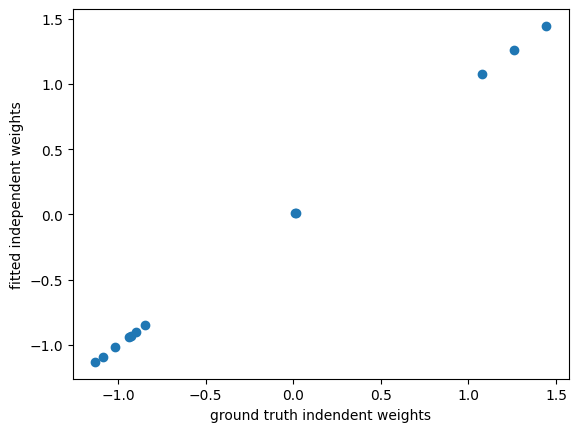

In [19]:
plt.scatter(model.independent_weights, weights[fit_model.independent_indices])
plt.xlabel("ground truth indendent weights") 
plt.ylabel('fitted independent weights') 

Text(0, 0.5, 'fitted pairwise weights')

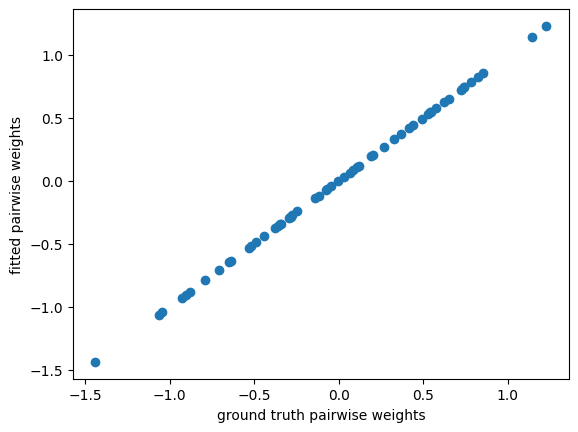

In [20]:
plt.scatter(model.pairwise_weights, weights[fit_model.pairwise_indices])
plt.xlabel("ground truth pairwise weights") 
plt.ylabel('fitted pairwise weights') 

In [ ]:
a, b = np.linalg.eig(fit_model.features.T.dot(fit_model.features))

In [ ]:
plt.plot(a)

In [ ]:
fit_model.encoder.code_length_independent

In [ ]:
fit_model.encoder.code_length_pairwise

In [ ]:
np.sum(a < 0.0001)

In [ ]:
import numpy as np
from scipy.linalg import null_space

mat = fit_model.features.T.dot(fit_model.features)
ns = null_space(mat)

# Print the basis vectors of the null space
print("Null space basis vectors:")
print(ns.T)

In [ ]:
Q.independent_position_weights_name

In [ ]:
Q.pair_position_weights_name

In [ ]:
plt.plot(ns) 
_ = plt.xticks(range(Q.number_of_features), np.concatenate([Q.flattened_independent_position_weights_name, Q.flattened_pair_position_weights_name]), rotation = 90)



In [ ]:
Q.parent

In [ ]:
Q.pairwise_code_mapper

In [ ]:
Q.independent_code_mapper

In [ ]:
np.shape(ns)

In [ ]:
Q.feature_names_independent

In [ ]:
np.shape(model.pairwise_constraints)

In [ ]:
Q.feature_names_pairwise

In [ ]:
Q.flattened_pair_position_weights_name